In [197]:
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import random
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
import shutil

In [190]:
# Download the dataset

rf = Roboflow(api_key="KhV6y3SVx0M66EFe23Vv")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(9)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...


In [191]:
# Get class count

def count_classes(base_dir, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    
    for root, _, files in os.walk(base_dir):
        if 'labels' in root:  # Process only the 'labels' directories
            for label_file in files:
                with open(os.path.join(root, label_file), 'r') as file:
                    lines = file.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])
                        class_counts[class_names[class_id]] += 1
    
    print(class_counts)
    return class_counts

In [192]:
# Plot the class count

def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in YOLO Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [193]:
base_dir = 'C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9'
class_names = ['ball', 'goalkeeper', 'player', 'referee']  # Update with your actual class names
    
original_class_counts  = count_classes(base_dir, class_names)
plot_class_distribution(original_class_counts )

KeyboardInterrupt: 

In [ ]:
# Define augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomCrop(width=450, height=450, p=0.5),
    A.GaussianBlur(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.OneOf([
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
        A.RandomFog(p=0.2),
        A.RandomSunFlare(p=0.2)
    ], p=0.3),  # Add weather augmentation with a 30% probability
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [ ]:
# Define paths
base_dir = 'C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9'
output_dir = 'C:/Users/Houssem/Desktop/pytorch/backend/augmented_dataset'
class_names = ['ball', 'goalkeeper', 'player', 'referee']
classes_to_augment = ['ball', 'goalkeeper', 'referee']

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Get the image, bboxes and class label for each image in the dataset

def load_image_and_labels(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    with open(label_path, 'r') as file:
        labels = file.readlines()
    bboxes = []
    class_labels = []
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.split())
        class_labels.append(class_names[int(class_id)])
        bboxes.append([x_center, y_center, width, height])
    return image, bboxes, class_labels, h, w

In [ ]:
# Save the augmented label and image

def save_augmented_image_and_labels(image, bboxes, class_labels, original_image_path, original_label_path, output_image_dir, output_label_dir, counter):
    image_name = os.path.splitext(os.path.basename(original_image_path))[0]
    label_name = os.path.splitext(os.path.basename(original_label_path))[0]

    augmented_image_path = os.path.join(output_image_dir, f"{image_name}_aug_{counter}.jpg")
    augmented_label_path = os.path.join(output_label_dir, f"{label_name}_aug_{counter}.txt")

    # Convert the tensor image back to a NumPy array
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).cpu().numpy()


    cv2.imwrite(augmented_image_path, image)
    
    with open(augmented_label_path, 'w') as file:
        for bbox, class_label in zip(bboxes, class_labels):
            class_id = class_names.index(class_label)
            file.write(f"{class_id} " + " ".join(map(str, bbox)) + "\n")

In [ ]:
# Process each directory
for folder in ['test', 'train', 'valid']:
    image_dir = os.path.join(base_dir, folder, 'images')
    label_dir = os.path.join(base_dir, folder, 'labels')

    output_image_dir = os.path.join(output_dir, folder, 'images')
    output_label_dir = os.path.join(output_dir, folder, 'labels')

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for label_file in tqdm(os.listdir(label_dir)):
        label_path = os.path.join(label_dir, label_file)
        image_path = os.path.join(image_dir, label_file.replace('.txt', '.jpg'))

        image, bboxes, class_labels, h, w = load_image_and_labels(image_path, label_path)

        if any(cls in class_labels for cls in classes_to_augment):
            for i in range(10):  # Number of augmentations per image
                augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
                augmented_image = augmented['image']
                augmented_bboxes = augmented['bboxes']
                augmented_class_labels = augmented['class_labels']

                save_augmented_image_and_labels(augmented_image, augmented_bboxes, augmented_class_labels, image_path, label_path, output_image_dir, output_label_dir, i)

print("Augmentation complete.")

100%|██████████| 43/43 [01:17<00:00,  1.81s/it]

Augmentation complete.


{'ball': 1615, 'goalkeeper': 1241, 'player': 37368, 'referee': 4110}


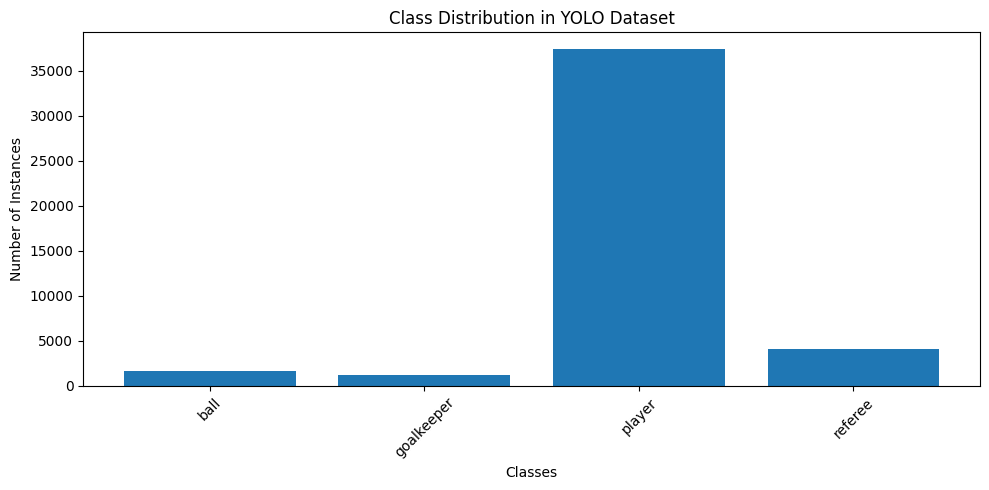

In [ ]:
#Check the new class distribution after augmentations

base_dir = 'C:/Users/Houssem/Desktop/pytorch/backend/augmented_dataset'
class_names = ['ball', 'goalkeeper', 'player', 'referee']  # Update with your actual class names
    
augmented_class_counts  = count_classes(base_dir, class_names)
plot_class_distribution(augmented_class_counts )

In [ ]:
# Plot class distributions
def plot_combined_class_distribution(original_counts, augmented_counts, class_names, title):
    labels = class_names
    original_values = [original_counts[cls] for cls in class_names]
    augmented_values = [augmented_counts[cls] for cls in class_names]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, original_values, width, label='Original')
    rects2 = ax.bar(x + width/2, augmented_values, width, label='Augmented')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Instances')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar in *rects*, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.xticks(rotation=45)
    plt.show()

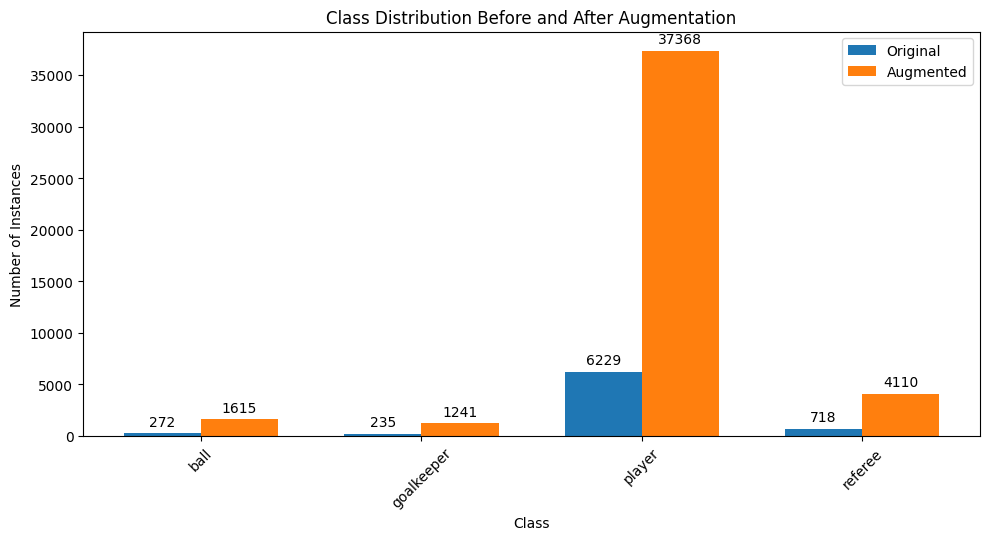

In [ ]:
# plot combined class distribution

plot_combined_class_distribution(original_class_counts, augmented_class_counts, class_names, 'Class Distribution Before and After Augmentation')

In [ ]:
def load_images_from_folder(folder, num_images=10):
    images = []
    filenames = sorted(os.listdir(folder))[:num_images]
    random_filenames = random.sample(filenames, num_images)
    for filename in random_filenames:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [ ]:
def display_images(original_images, augmented_images):
    num_images = min(len(original_images), len(augmented_images))
    plt.figure(figsize=(15, num_images * 5))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image", fontsize = 10)
        plt.axis('off')
        
        # Augmented image
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(augmented_images[i])
        plt.title("Augmented Image", fontsize = 10)
        plt.axis('off')
        
    plt.show()

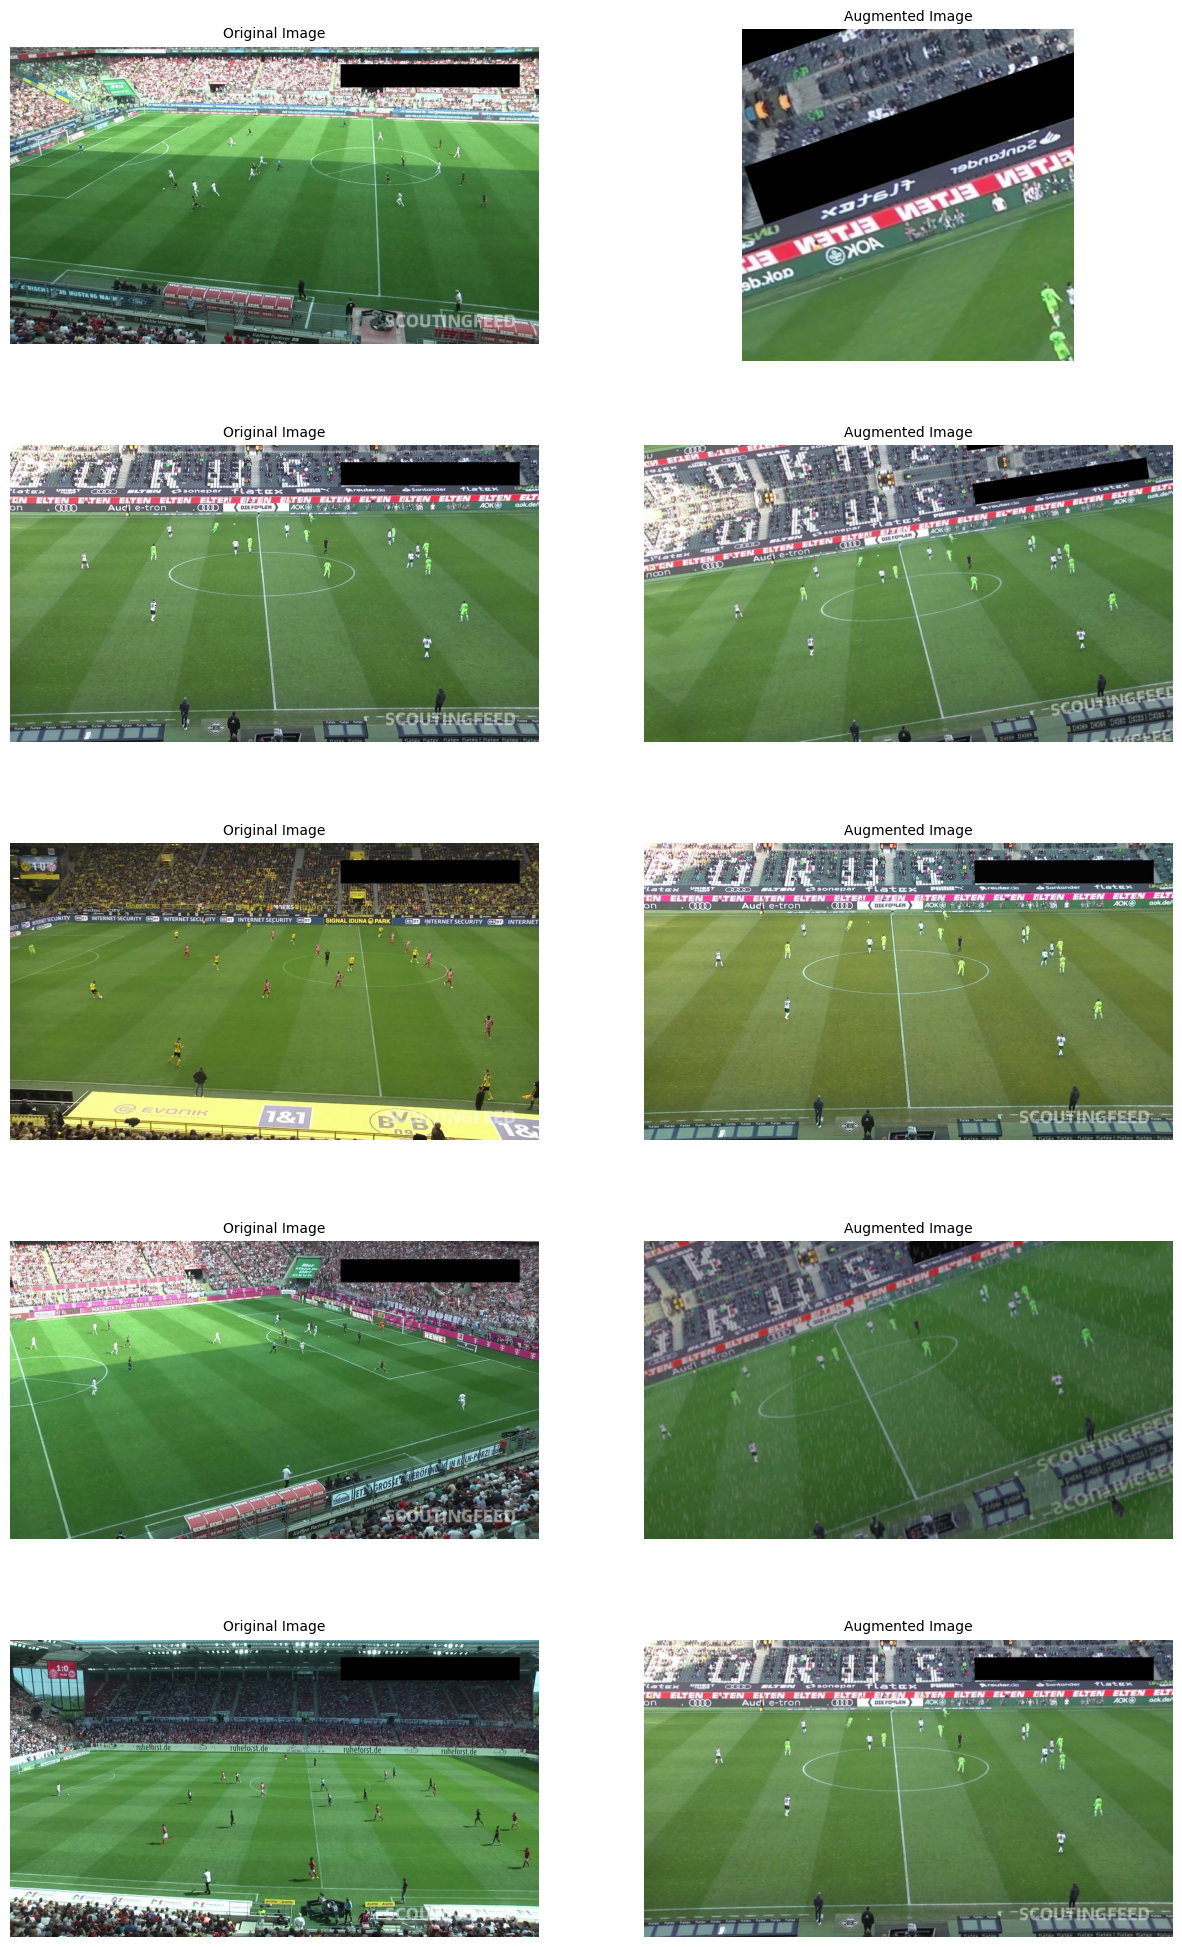

In [ ]:
# Load images from the original dataset
original_image_folder = 'C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9/test/images'
original_images = load_images_from_folder(original_image_folder, num_images=5)

# Load images from the augmented dataset
augmented_image_folder = 'C:/Users/Houssem/Desktop/pytorch/backend/augmented_dataset/test/images'
augmented_images = load_images_from_folder(augmented_image_folder, num_images=5)

# Display original and augmented images
display_images(original_images, augmented_images)

In [552]:
model = YOLO('C:/Users/Houssem/Desktop/pytorch/backend/best.pt')

In [553]:
#model.eval()
# Display model information (optional)
model.model.eval()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): RepNCSPELAN4(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Sequential(
        (0): RepCSP(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, 

In [551]:
use_cuda=True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('C:/Users/Houssem/Desktop/pytorch/backend/best.pt' , map_location=device))

RuntimeError: Error(s) in loading state_dict for YOLO:
	Missing key(s) in state_dict: "model.model.0.conv.weight", "model.model.0.conv.bias", "model.model.1.conv.weight", "model.model.1.conv.bias", "model.model.2.cv1.conv.weight", "model.model.2.cv1.conv.bias", "model.model.2.cv2.0.cv1.conv.weight", "model.model.2.cv2.0.cv1.conv.bias", "model.model.2.cv2.0.cv2.conv.weight", "model.model.2.cv2.0.cv2.conv.bias", "model.model.2.cv2.0.cv3.conv.weight", "model.model.2.cv2.0.cv3.conv.bias", "model.model.2.cv2.0.m.0.cv1.conv.weight", "model.model.2.cv2.0.m.0.cv1.conv.bias", "model.model.2.cv2.0.m.0.cv2.conv.weight", "model.model.2.cv2.0.m.0.cv2.conv.bias", "model.model.2.cv2.1.conv.weight", "model.model.2.cv2.1.conv.bias", "model.model.2.cv3.0.cv1.conv.weight", "model.model.2.cv3.0.cv1.conv.bias", "model.model.2.cv3.0.cv2.conv.weight", "model.model.2.cv3.0.cv2.conv.bias", "model.model.2.cv3.0.cv3.conv.weight", "model.model.2.cv3.0.cv3.conv.bias", "model.model.2.cv3.0.m.0.cv1.conv.weight", "model.model.2.cv3.0.m.0.cv1.conv.bias", "model.model.2.cv3.0.m.0.cv2.conv.weight", "model.model.2.cv3.0.m.0.cv2.conv.bias", "model.model.2.cv3.1.conv.weight", "model.model.2.cv3.1.conv.bias", "model.model.2.cv4.conv.weight", "model.model.2.cv4.conv.bias", "model.model.3.cv1.conv.weight", "model.model.3.cv1.conv.bias", "model.model.3.cv2.conv.weight", "model.model.3.cv2.conv.bias", "model.model.4.cv1.conv.weight", "model.model.4.cv1.conv.bias", "model.model.4.cv2.0.cv1.conv.weight", "model.model.4.cv2.0.cv1.conv.bias", "model.model.4.cv2.0.cv2.conv.weight", "model.model.4.cv2.0.cv2.conv.bias", "model.model.4.cv2.0.cv3.conv.weight", "model.model.4.cv2.0.cv3.conv.bias", "model.model.4.cv2.0.m.0.cv1.conv.weight", "model.model.4.cv2.0.m.0.cv1.conv.bias", "model.model.4.cv2.0.m.0.cv2.conv.weight", "model.model.4.cv2.0.m.0.cv2.conv.bias", "model.model.4.cv2.1.conv.weight", "model.model.4.cv2.1.conv.bias", "model.model.4.cv3.0.cv1.conv.weight", "model.model.4.cv3.0.cv1.conv.bias", "model.model.4.cv3.0.cv2.conv.weight", "model.model.4.cv3.0.cv2.conv.bias", "model.model.4.cv3.0.cv3.conv.weight", "model.model.4.cv3.0.cv3.conv.bias", "model.model.4.cv3.0.m.0.cv1.conv.weight", "model.model.4.cv3.0.m.0.cv1.conv.bias", "model.model.4.cv3.0.m.0.cv2.conv.weight", "model.model.4.cv3.0.m.0.cv2.conv.bias", "model.model.4.cv3.1.conv.weight", "model.model.4.cv3.1.conv.bias", "model.model.4.cv4.conv.weight", "model.model.4.cv4.conv.bias", "model.model.5.cv1.conv.weight", "model.model.5.cv1.conv.bias", "model.model.5.cv2.conv.weight", "model.model.5.cv2.conv.bias", "model.model.6.cv1.conv.weight", "model.model.6.cv1.conv.bias", "model.model.6.cv2.0.cv1.conv.weight", "model.model.6.cv2.0.cv1.conv.bias", "model.model.6.cv2.0.cv2.conv.weight", "model.model.6.cv2.0.cv2.conv.bias", "model.model.6.cv2.0.cv3.conv.weight", "model.model.6.cv2.0.cv3.conv.bias", "model.model.6.cv2.0.m.0.cv1.conv.weight", "model.model.6.cv2.0.m.0.cv1.conv.bias", "model.model.6.cv2.0.m.0.cv2.conv.weight", "model.model.6.cv2.0.m.0.cv2.conv.bias", "model.model.6.cv2.1.conv.weight", "model.model.6.cv2.1.conv.bias", "model.model.6.cv3.0.cv1.conv.weight", "model.model.6.cv3.0.cv1.conv.bias", "model.model.6.cv3.0.cv2.conv.weight", "model.model.6.cv3.0.cv2.conv.bias", "model.model.6.cv3.0.cv3.conv.weight", "model.model.6.cv3.0.cv3.conv.bias", "model.model.6.cv3.0.m.0.cv1.conv.weight", "model.model.6.cv3.0.m.0.cv1.conv.bias", "model.model.6.cv3.0.m.0.cv2.conv.weight", "model.model.6.cv3.0.m.0.cv2.conv.bias", "model.model.6.cv3.1.conv.weight", "model.model.6.cv3.1.conv.bias", "model.model.6.cv4.conv.weight", "model.model.6.cv4.conv.bias", "model.model.7.cv1.conv.weight", "model.model.7.cv1.conv.bias", "model.model.7.cv2.conv.weight", "model.model.7.cv2.conv.bias", "model.model.8.cv1.conv.weight", "model.model.8.cv1.conv.bias", "model.model.8.cv2.0.cv1.conv.weight", "model.model.8.cv2.0.cv1.conv.bias", "model.model.8.cv2.0.cv2.conv.weight", "model.model.8.cv2.0.cv2.conv.bias", "model.model.8.cv2.0.cv3.conv.weight", "model.model.8.cv2.0.cv3.conv.bias", "model.model.8.cv2.0.m.0.cv1.conv.weight", "model.model.8.cv2.0.m.0.cv1.conv.bias", "model.model.8.cv2.0.m.0.cv2.conv.weight", "model.model.8.cv2.0.m.0.cv2.conv.bias", "model.model.8.cv2.1.conv.weight", "model.model.8.cv2.1.conv.bias", "model.model.8.cv3.0.cv1.conv.weight", "model.model.8.cv3.0.cv1.conv.bias", "model.model.8.cv3.0.cv2.conv.weight", "model.model.8.cv3.0.cv2.conv.bias", "model.model.8.cv3.0.cv3.conv.weight", "model.model.8.cv3.0.cv3.conv.bias", "model.model.8.cv3.0.m.0.cv1.conv.weight", "model.model.8.cv3.0.m.0.cv1.conv.bias", "model.model.8.cv3.0.m.0.cv2.conv.weight", "model.model.8.cv3.0.m.0.cv2.conv.bias", "model.model.8.cv3.1.conv.weight", "model.model.8.cv3.1.conv.bias", "model.model.8.cv4.conv.weight", "model.model.8.cv4.conv.bias", "model.model.9.cv1.conv.weight", "model.model.9.cv1.conv.bias", "model.model.9.cv5.conv.weight", "model.model.9.cv5.conv.bias", "model.model.12.cv1.conv.weight", "model.model.12.cv1.conv.bias", "model.model.12.cv2.0.cv1.conv.weight", "model.model.12.cv2.0.cv1.conv.bias", "model.model.12.cv2.0.cv2.conv.weight", "model.model.12.cv2.0.cv2.conv.bias", "model.model.12.cv2.0.cv3.conv.weight", "model.model.12.cv2.0.cv3.conv.bias", "model.model.12.cv2.0.m.0.cv1.conv.weight", "model.model.12.cv2.0.m.0.cv1.conv.bias", "model.model.12.cv2.0.m.0.cv2.conv.weight", "model.model.12.cv2.0.m.0.cv2.conv.bias", "model.model.12.cv2.1.conv.weight", "model.model.12.cv2.1.conv.bias", "model.model.12.cv3.0.cv1.conv.weight", "model.model.12.cv3.0.cv1.conv.bias", "model.model.12.cv3.0.cv2.conv.weight", "model.model.12.cv3.0.cv2.conv.bias", "model.model.12.cv3.0.cv3.conv.weight", "model.model.12.cv3.0.cv3.conv.bias", "model.model.12.cv3.0.m.0.cv1.conv.weight", "model.model.12.cv3.0.m.0.cv1.conv.bias", "model.model.12.cv3.0.m.0.cv2.conv.weight", "model.model.12.cv3.0.m.0.cv2.conv.bias", "model.model.12.cv3.1.conv.weight", "model.model.12.cv3.1.conv.bias", "model.model.12.cv4.conv.weight", "model.model.12.cv4.conv.bias", "model.model.15.cv1.conv.weight", "model.model.15.cv1.conv.bias", "model.model.15.cv2.0.cv1.conv.weight", "model.model.15.cv2.0.cv1.conv.bias", "model.model.15.cv2.0.cv2.conv.weight", "model.model.15.cv2.0.cv2.conv.bias", "model.model.15.cv2.0.cv3.conv.weight", "model.model.15.cv2.0.cv3.conv.bias", "model.model.15.cv2.0.m.0.cv1.conv.weight", "model.model.15.cv2.0.m.0.cv1.conv.bias", "model.model.15.cv2.0.m.0.cv2.conv.weight", "model.model.15.cv2.0.m.0.cv2.conv.bias", "model.model.15.cv2.1.conv.weight", "model.model.15.cv2.1.conv.bias", "model.model.15.cv3.0.cv1.conv.weight", "model.model.15.cv3.0.cv1.conv.bias", "model.model.15.cv3.0.cv2.conv.weight", "model.model.15.cv3.0.cv2.conv.bias", "model.model.15.cv3.0.cv3.conv.weight", "model.model.15.cv3.0.cv3.conv.bias", "model.model.15.cv3.0.m.0.cv1.conv.weight", "model.model.15.cv3.0.m.0.cv1.conv.bias", "model.model.15.cv3.0.m.0.cv2.conv.weight", "model.model.15.cv3.0.m.0.cv2.conv.bias", "model.model.15.cv3.1.conv.weight", "model.model.15.cv3.1.conv.bias", "model.model.15.cv4.conv.weight", "model.model.15.cv4.conv.bias", "model.model.16.cv1.conv.weight", "model.model.16.cv1.conv.bias", "model.model.16.cv2.conv.weight", "model.model.16.cv2.conv.bias", "model.model.18.cv1.conv.weight", "model.model.18.cv1.conv.bias", "model.model.18.cv2.0.cv1.conv.weight", "model.model.18.cv2.0.cv1.conv.bias", "model.model.18.cv2.0.cv2.conv.weight", "model.model.18.cv2.0.cv2.conv.bias", "model.model.18.cv2.0.cv3.conv.weight", "model.model.18.cv2.0.cv3.conv.bias", "model.model.18.cv2.0.m.0.cv1.conv.weight", "model.model.18.cv2.0.m.0.cv1.conv.bias", "model.model.18.cv2.0.m.0.cv2.conv.weight", "model.model.18.cv2.0.m.0.cv2.conv.bias", "model.model.18.cv2.1.conv.weight", "model.model.18.cv2.1.conv.bias", "model.model.18.cv3.0.cv1.conv.weight", "model.model.18.cv3.0.cv1.conv.bias", "model.model.18.cv3.0.cv2.conv.weight", "model.model.18.cv3.0.cv2.conv.bias", "model.model.18.cv3.0.cv3.conv.weight", "model.model.18.cv3.0.cv3.conv.bias", "model.model.18.cv3.0.m.0.cv1.conv.weight", "model.model.18.cv3.0.m.0.cv1.conv.bias", "model.model.18.cv3.0.m.0.cv2.conv.weight", "model.model.18.cv3.0.m.0.cv2.conv.bias", "model.model.18.cv3.1.conv.weight", "model.model.18.cv3.1.conv.bias", "model.model.18.cv4.conv.weight", "model.model.18.cv4.conv.bias", "model.model.19.cv1.conv.weight", "model.model.19.cv1.conv.bias", "model.model.19.cv2.conv.weight", "model.model.19.cv2.conv.bias", "model.model.21.cv1.conv.weight", "model.model.21.cv1.conv.bias", "model.model.21.cv2.0.cv1.conv.weight", "model.model.21.cv2.0.cv1.conv.bias", "model.model.21.cv2.0.cv2.conv.weight", "model.model.21.cv2.0.cv2.conv.bias", "model.model.21.cv2.0.cv3.conv.weight", "model.model.21.cv2.0.cv3.conv.bias", "model.model.21.cv2.0.m.0.cv1.conv.weight", "model.model.21.cv2.0.m.0.cv1.conv.bias", "model.model.21.cv2.0.m.0.cv2.conv.weight", "model.model.21.cv2.0.m.0.cv2.conv.bias", "model.model.21.cv2.1.conv.weight", "model.model.21.cv2.1.conv.bias", "model.model.21.cv3.0.cv1.conv.weight", "model.model.21.cv3.0.cv1.conv.bias", "model.model.21.cv3.0.cv2.conv.weight", "model.model.21.cv3.0.cv2.conv.bias", "model.model.21.cv3.0.cv3.conv.weight", "model.model.21.cv3.0.cv3.conv.bias", "model.model.21.cv3.0.m.0.cv1.conv.weight", "model.model.21.cv3.0.m.0.cv1.conv.bias", "model.model.21.cv3.0.m.0.cv2.conv.weight", "model.model.21.cv3.0.m.0.cv2.conv.bias", "model.model.21.cv3.1.conv.weight", "model.model.21.cv3.1.conv.bias", "model.model.21.cv4.conv.weight", "model.model.21.cv4.conv.bias", "model.model.22.cv2.0.0.conv.weight", "model.model.22.cv2.0.0.conv.bias", "model.model.22.cv2.0.1.conv.weight", "model.model.22.cv2.0.1.conv.bias", "model.model.22.cv2.0.2.weight", "model.model.22.cv2.0.2.bias", "model.model.22.cv2.1.0.conv.weight", "model.model.22.cv2.1.0.conv.bias", "model.model.22.cv2.1.1.conv.weight", "model.model.22.cv2.1.1.conv.bias", "model.model.22.cv2.1.2.weight", "model.model.22.cv2.1.2.bias", "model.model.22.cv2.2.0.conv.weight", "model.model.22.cv2.2.0.conv.bias", "model.model.22.cv2.2.1.conv.weight", "model.model.22.cv2.2.1.conv.bias", "model.model.22.cv2.2.2.weight", "model.model.22.cv2.2.2.bias", "model.model.22.cv3.0.0.conv.weight", "model.model.22.cv3.0.0.conv.bias", "model.model.22.cv3.0.1.conv.weight", "model.model.22.cv3.0.1.conv.bias", "model.model.22.cv3.0.2.weight", "model.model.22.cv3.0.2.bias", "model.model.22.cv3.1.0.conv.weight", "model.model.22.cv3.1.0.conv.bias", "model.model.22.cv3.1.1.conv.weight", "model.model.22.cv3.1.1.conv.bias", "model.model.22.cv3.1.2.weight", "model.model.22.cv3.1.2.bias", "model.model.22.cv3.2.0.conv.weight", "model.model.22.cv3.2.0.conv.bias", "model.model.22.cv3.2.1.conv.weight", "model.model.22.cv3.2.1.conv.bias", "model.model.22.cv3.2.2.weight", "model.model.22.cv3.2.2.bias", "model.model.22.dfl.conv.weight". 
	Unexpected key(s) in state_dict: "epoch", "best_fitness", "ema", "updates", "optimizer", "train_args", "train_metrics", "train_results", "date", "version", "license", "docs". 

In [ ]:
image = cv2.imread("C:/Users/Houssem/Desktop/pytorch/backend/augmented_dataset/train/images/2e57b9_1_8_png.rf.3ad6daa99d04cabafdb0a2d7a80d68dc_aug_4.jpg")
 
results = model(image)

print(results)

In [535]:
def extract_results_info(results):
    
    boxes = results.boxes.xyxy  # Bounding boxes (x1, y1, x2, y2)
    scores = results.boxes.conf  # Confidence scores
    labels = results.boxes.cls   # Class labels

    return {
        'boxes' : boxes.clone().detach().requires_grad_(True),
        'labels': labels.clone().detach().requires_grad_(True),
        'scores': scores.clone().detach().requires_grad_(True)  # Assuming scores of 1.0 for ground truth
    }
    #return {'boxes': boxes, 'scores': scores, 'labels': labels}

In [666]:
# YOLO loss function
def yolo_loss(predictions, targets, lambda_coord=5, lambda_noobj=0.5):
    # Extract predicted boxes, objectness scores, and class probabilities
    
    predicted_bboxes = predictions['boxes']
    predicted_obj_scores = predictions['scores']
    predicted_class_probs = predictions['labels']
    
    target_bboxes = targets['boxes']
    target_obj_scores = targets['scores']
    target_class_probs = targets['labels']

    # Check if number of predicted boxes matches number of target boxes
    if predicted_bboxes.shape[0] != target_bboxes.shape[0]:
        print(f"Skipping loss calculation for this image. Predicted boxes: {predicted_bboxes.shape[0]}, Target boxes: {target_bboxes.shape[0]}")
        return None
    
    # Bounding Box Loss (MSE Loss)
    bbox_loss = F.mse_loss(predicted_bboxes, target_bboxes)
    #print(f'bbox_loss : {bbox_loss}')
    
    # Objectness Loss (BCE Loss)
    obj_loss = F.binary_cross_entropy_with_logits(predicted_obj_scores, target_obj_scores)
    #print(f'obj_loss : {obj_loss}')
    
    # Class Probability Loss (BCE Loss)
    class_loss = F.binary_cross_entropy_with_logits(predicted_class_probs, target_class_probs)
    #print(f'class_loss : {class_loss}')
    
    # Total Loss
    total_loss = lambda_coord * bbox_loss + obj_loss + lambda_noobj * class_loss
    #total_losss =  torch.tensor(total_loss, dtype=torch.float64 , requires_grad=True)
    return total_loss

In [537]:
# Define FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [772]:
def generate_adversarial_samples(image_tensor, target, epsilon=0.01):
    image_tensor.requires_grad = True

    model.model.eval()

    #print(f'Image tensor type : {type(image_tensor)}')

    #model.eval()  # Ensure model is in training mode
    
    # Forward pass through the model
    #output = model.predict(image_tensor)[0]  # Assuming YOLO model returns a list and we take the first result
    
    # Forward pass through the model
    #with torch.enable_grad():
    output = model(image_tensor)[0]  # Assuming YOLO model returns a list and we take the first result

    #print(f'output : {output}')

    #print(f'ouput type : { type(output)}')
    
    predictions = extract_results_info(output)

    # Print number of predicted and target boxes
    #print(f"Predicted boxes: {len(predictions['boxes'])}, Target boxes: {len(target['boxes'])}")

    #print(f"predictions : {predictions['boxes']}")

    # Calculate loss (check for mismatch and skip if necessary)
    loss = yolo_loss(predictions, target)

    if loss is None:
        print("Skipping adversarial sample generation for this image.")
        return None, None
    
    
    #print(f'loss : {type(loss)}')

    #model.train()

    # Backpropagation
    model.zero_grad()
    loss.backward()

    #print(f'image_tensore : {type(image_tensor)}')

    print(f'image_tensor : {image_tensor.grad}')
    
    # Gradient calculation
    image_grad = image_tensor.grad.data
    
    # FGSM attack to generate perturbed image
    perturbed_image = fgsm_attack(image_tensor, epsilon, image_grad)
    
    return perturbed_image, loss

In [574]:
def get_target_for_image(image_path, label_folder):
    
    image_filename = os.path.basename(image_path)
    label_filename = os.path.splitext(image_filename)[0] + '.txt'
    label_path = os.path.join(label_folder, label_filename)

    boxes = []
    labels = []
    
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_label = int(parts[0])
            center_x = float(parts[1])
            center_y = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            
            # Convert YOLO format (center_x, center_y, width, height) to (x1, y1, x2, y2)
            x1 = center_x - (width / 2)
            y1 = center_y - (height / 2)
            x2 = center_x + (width / 2)
            y2 = center_y + (height / 2)
            
            boxes.append([x1, y1, x2, y2])
            labels.append(class_label)
    
    target = {
        'boxes': torch.tensor(boxes, dtype=torch.float32 , requires_grad=True),
        'labels': torch.tensor(labels, dtype=torch.float64 , requires_grad=True),
        'scores': torch.tensor([1.0] * len(boxes), dtype=torch.float32 , requires_grad=True)  # Assuming scores of 1.0 for ground truth
    }
    
    return target

In [769]:
def process_adv_dataset(main_folder, output_folder, epsilon=0.01, num_images=10):
    splits = ['train', 'valid', 'test']
    
    for split in splits:
        image_folder = os.path.join(main_folder, split, 'images')
        label_folder = os.path.join(main_folder, split, 'labels')
        
        output_image_folder = os.path.join(output_folder, split, 'images')
        output_label_folder = os.path.join(output_folder, split, 'labels')
        os.makedirs(output_image_folder, exist_ok=True)
        os.makedirs(output_label_folder, exist_ok=True)

        transform = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize((640, 640)),
        ])

        to_pil = ToPILImage()

        for img_path in os.listdir(image_folder)[:num_images]:
            #image_path = os.path.join(image_folder,img_path)
            #print(f'image_path : {image_path}')
            img = cv2.imread(os.path.join(image_folder, img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            #img_rgb = cv2.resize(image, (640, 640))
            #img_rgb = img_rgb.permute(2,0,1)
            

            #img_tensor = torch.tensor(img_rgb , dtype=torch.float32 , requires_grad=True)
            
            #img_tensor = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
            #img_tensor = img_tensor.clone().detach().requires_grad_(True)
            #img_tensor = img_tensor / 255.0
            #img_tensor = img_tensor.permute(2,0,1).unsqueeze(0)

            #img_tensor = transform(img_tensor)

            img_tensor = transform(img_rgb).unsqueeze(0)

            #print(f'img_rgb : { img_tensor.shape}')
            
            
        
            # Check the shape and values
            #print(f'Original image shape: {img_rgb.shape}, Transformed tensor shape: {img_tensor.shape}')
            #print(f'Max value in img_tensor: {img_tensor.max()}, Min value: {img_tensor.min()}')

            
            #img_tensor = img_tensor.clone().detach().requires_grad_(True)  # Make it a leaf tensor and enable gradient
            #print(f'Leaf tensor status: {img_tensor.is_leaf}, Requires grad: {img_tensor.requires_grad}')
            

            # Get the corresponding target for each image
            target = get_target_for_image(os.path.join(image_folder, img_path), label_folder)

            #print(f'target : {target}')
            
            perturbed_img_tensor, loss = generate_adversarial_samples(img_tensor, target, epsilon)

            # Skip if both perturbed_img_tensor and loss are None
            if perturbed_img_tensor is None and loss is None:
                continue

            perturbed_img = perturbed_img_tensor.squeeze(0).detach().cpu()

            # Save perturbed images (assuming filenames are kept in sync)
            filename = os.path.basename(img_path)
            output_image_path = os.path.join(output_image_folder, filename)
            to_pil(perturbed_img).save(output_image_path)
            #transforms.ToPILImage()(perturbed_img).save(output_image_path)
            # Copy the label file to the output folder
            label_file = os.path.join(label_folder, os.path.splitext(filename)[0] + '.txt')
            output_label_file = os.path.join(output_label_folder, os.path.splitext(filename)[0] + '.txt')
            if os.path.exists(label_file):
                shutil.copy(label_file, output_label_file)

In [773]:
# Process train, valid, and test sets
process_adv_dataset('C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9/', 'C:/Users/Houssem/Desktop/pytorch/backend/adversarial/', epsilon=0.01, num_images=10)
process_adv_dataset('C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9/', 'C:/Users/Houssem/Desktop/pytorch/backend/adversarial/', epsilon=0.01, num_images=10)
process_adv_dataset('C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9/', 'C:/Users/Houssem/Desktop/pytorch/backend/adversarial/', epsilon=0.01, num_images=10)


0: 640x640 20 players, 3 referees, 1178.9ms
Speed: 0.0ms preprocess, 1178.9ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)
Skipping loss calculation for this image. Predicted boxes: 23, Target boxes: 24
Skipping adversarial sample generation for this image.

0: 640x640 22 players, 3 referees, 1731.7ms
Speed: 0.0ms preprocess, 1731.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)
Skipping loss calculation for this image. Predicted boxes: 25, Target boxes: 26
Skipping adversarial sample generation for this image.

0: 640x640 20 players, 3 referees, 1658.4ms
Speed: 0.0ms preprocess, 1658.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)
Skipping loss calculation for this image. Predicted boxes: 23, Target boxes: 25
Skipping adversarial sample generation for this image.

0: 640x640 21 players, 2 referees, 1712.5ms
Speed: 0.0ms preprocess, 1712.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)
image_tensor : Non

AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
# Example usage: Load, generate adversarial samples, and save them
def process_dataset(folder, output_folder, epsilon=0.01, num_images=10):
    image_folder = os.path.join(folder, 'images')
    label_folder = os.path.join(folder, 'labels')
    
    output_image_folder = os.path.join(output_folder, 'images')
    output_label_folder = os.path.join(output_folder, 'labels')
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)

    images = load_images_from_folder(image_folder, num_images)
    transform = transforms.Compose([transforms.ToTensor()])
    
    for img, filename in images:
        img_tensor = transform(img).unsqueeze(0)
        perturbed_img_tensor = generate_adversarial_samples(img_tensor, epsilon)
        perturbed_img = perturbed_img_tensor.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
        perturbed_img = (perturbed_img * 255).astype(np.uint8)
        
        # Save perturbed images
        output_image_path = os.path.join(output_image_folder, filename)
        Image.fromarray(perturbed_img).save(output_image_path)
        
        # Copy corresponding label file
        label_filename = filename.replace('.jpg', '.txt')
        original_label_path = os.path.join(label_folder, label_filename)
        output_label_path = os.path.join(output_label_folder, label_filename)
        if os.path.exists(original_label_path):
            with open(original_label_path, 'r') as label_file:
                labels = label_file.read()
            with open(output_label_path, 'w') as output_label_file:
                output_label_file.write(labels)

In [ ]:
# Process train, valid, and test sets
process_dataset('dataset/train', 'dataset_adv/train', epsilon=0.01, num_images=10)
process_dataset('dataset/valid', 'dataset_adv/valid', epsilon=0.01, num_images=10)
process_dataset('dataset/test', 'dataset_adv/test', epsilon=0.01, num_images=10)

In [23]:
# Define augmentation pipeline including bbox transformations and label fields
transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [17]:
# Function to read annotations, apply augmentations, and save the results
def augment_and_save(image_path, annotations_path, save_dir, transform):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found")

    # Load corresponding annotation file
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    bboxes = []
    class_labels = []

    for annotation in annotations:
        parts = annotation.strip().split()
        class_label = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        bboxes.append([x_center, y_center, width, height])
        class_labels.append(class_label)

    # Apply augmentations
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']
    augmented_class_labels = augmented['class_labels']

    # Save augmented image
    image_name = os.path.basename(image_path)
    save_path = os.path.join(save_dir, 'images', image_name)
    cv2.imwrite(save_path, augmented_image)

    # Save adjusted bounding box annotations
    save_annotation_path = os.path.join(save_dir, 'labels', image_name.replace('.jpg', '.txt'))
    with open(save_annotation_path, 'w') as f:
        for bbox, class_label in zip(augmented_bboxes, augmented_class_labels):
            x_center, y_center, width, height = bbox
            f.write(f"{class_label} {x_center} {y_center} {width} {height}\n")

In [24]:
# Apply augmentations to all images and save
dataset_dir = 'C:/Users/Houssem/Desktop/pytorch/backend/football-players-detection-9'
folders = ['train', 'valid', 'test']

for folder in folders:
    images_dir = os.path.join(dataset_dir, folder, 'images')
    labels_dir = os.path.join(dataset_dir, folder, 'labels')
    augmented_dir = os.path.join(dataset_dir, folder + '_augmented')

    os.makedirs(os.path.join(augmented_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(augmented_dir, 'labels'), exist_ok=True)

    image_paths = glob(os.path.join(images_dir, '*.jpg'))

    for image_path in image_paths:
        annotation_path = os.path.join(labels_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
        augment_and_save(image_path, annotation_path, augmented_dir, transform)

FASTER R CNN

In [ ]:
# Importation 



In [778]:
# Download the dataset 

from roboflow import Roboflow
rf = Roboflow(api_key="KhV6y3SVx0M66EFe23Vv")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(9)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...
